In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import lightgbm as lgbm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold
# from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from optuna import integration, logging
from itertools import product

from sklearn.metrics import f1_score


In [2]:
# each prediction
train_origin = pl.read_csv("data/train.csv")
oof_pred_df_lst = [pl.read_csv("pred/oof_pred_lgbm_feat01.csv"), 
                   pl.read_csv("pred/oof_pred_catboost_feat00.csv")]

### train layer2 model (logistic regression)

In [3]:
# Layer2特徴量：各モデルの予測確率
train = pl.concat([oof_pred_df.select(pl.all().name.prefix(f"model{i}_")) 
                   for i, oof_pred_df in enumerate(oof_pred_df_lst)], how="horizontal")
cols_exp = train.columns

# 予測ターゲット
train = train.with_columns(train_origin["health"])
col_target = "health"

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

x = train[cols_exp].to_numpy()
y = train[col_target].to_numpy()

# 学習データ全体でstandard scalerをfitting (testのstackingで利用される想定)
scaler_all = StandardScaler()
scaler_all.fit(x)

# cross validation
# skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
kf = KFold(n_splits=5, random_state=42, shuffle=True)
y_valid_pred_lst = []
idx_valid_lst = []
clf_lst = []

for fold, (idx_train, idx_valid) in enumerate(kf.split(x)):
    # partitioning
    x_train = x[idx_train, :]
    x_valid = x[idx_valid, :]
    y_train = y[idx_train]
    y_valid = y[idx_valid]
    
    # normalization
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_valid = scaler.transform(x_valid)
    
    # training layer2
    clf = LogisticRegression(
        random_state=42, 
        max_iter=1000
    )
    clf.fit(x_train, y_train)
    
    # oof
    y_valid_pred = clf.predict_proba(x_valid)
    y_valid_pred_lst.append(y_valid_pred)
    idx_valid_lst.append(idx_valid)
    clf_lst.append(clf)

idx_valid = np.hstack(idx_valid_lst)
y_valid_pred = np.vstack(y_valid_pred_lst)
oof_pred = y_valid_pred[np.argsort(idx_valid)]

# to dataframe
oof_pred_df = pl.DataFrame(oof_pred, schema=[f"health_is_{h}" for h in range(3)])

### check CV score

In [6]:
def threshold_tuning(test_pred_df, dp0_lst, dp1_lst, weights_train):
    """
    F1スコア期待値が最大になる判定閾値を探索。
    各クラスの件数率が、train-testで最小化となる判定閾値を探す
    """

    rec = []
    dp0_dp1_lst = list(product(dp0_lst, dp1_lst))

    for dp0, dp1 in tqdm(dp0_dp1_lst):
        # if not dp0 + dp1 >= -1/3: # 境界条件
        #     continue
                
        # 判定閾値をナイーブベース(1/3, 1/3)からスライド
        dp_df = test_pred_df.with_columns([pl.col("health_is_0") + dp0, 
                                        pl.col("health_is_1") + dp1, 
                                        pl.col("health_is_2") - dp0 - dp1])

        # スライドした閾値に基づくクラス分類
        pred_label = np.argmax(dp_df, axis=1) 

        # 各クラスに属するデータ件数率を求める
        weights_test = np.array([(pred_label == h).sum() for h in range(3)]) / len(test_pred_df)

        # train/testのデータ件数率の絶対誤差
        err = np.abs(weights_train - weights_test).sum()
        rec.append([dp0, dp1, err])

    # to dataframe
    rec_df = pl.DataFrame(np.array(rec), schema=["dp0", "dp1", "err"])
    # rec_df.write_csv("feat/grid_search_threshold.csv")

    # visualize with contour
    dp0_grids, dp1_grids = np.meshgrid(dp0_lst, dp1_lst)
    zvis_max = 0.5
    # dp0min, dp0max = 0.135, 0.136
    # dp1min, dp1max = -0.4205, -0.4195
                
    z = np.array(rec_df["err"]).reshape(dp0_grids.shape[::-1]).T
    zvis = np.stack([z, zvis_max*np.ones_like(z)]).min(axis=0)

    # 最適パラメータの特定 & record
    grid_min = np.where(z - z.min() < 1e-12)
    dp0_opt = dp0_grids[grid_min][0]
    dp1_opt = dp1_grids[grid_min][0]

    # visualize
    fig, ax = plt.subplots(figsize=(6, 6))
    cs = ax.contour(dp0_grids, dp1_grids, zvis, colors="black", linewidths=0.5)
    ax.clabel(cs)
    cs = ax.contourf(dp0_grids, dp1_grids, zvis, cmap="Reds")
    fig.colorbar(mappable=cs)
    ax.set_xlabel("dp0")
    ax.set_ylabel("dp1")
    # ax.set_xlim(dp0min, dp0max)
    # ax.set_ylim(dp1min, dp1max)
    ax.grid()
    ax.scatter(dp0_opt, dp1_opt, color="r", label=f"min_loss: (dp0, dp1) = ({dp0_opt:.5f}, {dp1_opt:.5f})")
    ax.legend()
    plt.show()
    plt.close()
    
    return dp0_opt, dp1_opt

In [7]:
# 解像度を1e-4, 1e-5と細かく実験したが精度向上にはつながらない
dp0_lst = np.arange(0.05, 0.25, 1e-3)
dp1_lst = np.arange(-0.45, -0.35, 1e-3)

In [8]:
# trainにおける、各クラスのデータ件数率
weights_train = np.array(train_origin["health"].value_counts().sort("health")["count"]) / len(train_origin)
weights_train

array([0.17689151, 0.78818054, 0.03492794])

  0%|          | 0/20200 [00:00<?, ?it/s]

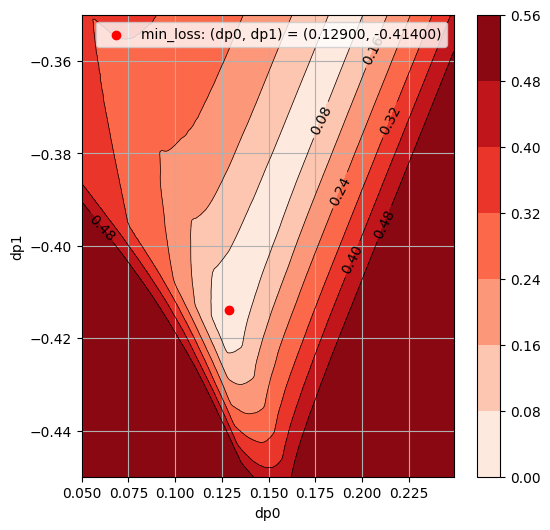

CV score: f1 = 0.37763888207777274


In [9]:
# tureshold_tuning
dp0_opt, dp1_opt = threshold_tuning(oof_pred_df, dp0_lst, dp1_lst, weights_train)

# 判定閾値をナイーブベース(1/3, 1/3)からスライド
dp_df = oof_pred_df.with_columns([pl.col("health_is_0") + dp0_opt, 
                            pl.col("health_is_1") + dp1_opt, 
                            pl.col("health_is_2") - dp0_opt - dp1_opt])

# スライドした閾値に基づくクラス分類
pred_label = np.argmax(dp_df, axis=1) 

# calcurate f1 score
true_label = train_origin["health"].to_numpy()
f1 = f1_score(true_label, pred_label, average="macro")
print("CV score: f1 =", f1)

### calcurate prob of test

In [10]:
def predict_test(x_test, clf_lst):
    y_test_pred_lst = []

    for clf in clf_lst:
        y_test_pred = clf.predict_proba(x_test)
        y_test_pred_lst.append(y_test_pred)

    y_test_pred = np.mean(y_test_pred_lst, axis=0)
    return y_test_pred

In [11]:
# each prediction
test_pred_df_lst = [pl.read_csv("pred/test_pred_lgbm_feat01.csv"), 
                   pl.read_csv("pred/test_pred_catboost_feat00.csv")]
test = pl.concat([pred_df.select(pl.all().name.prefix(f"model{i}_")) 
                   for i, pred_df in enumerate(test_pred_df_lst)], how="horizontal")

# normalization
x_test = scaler_all.transform(test[cols_exp].to_numpy())

# calcurate ensemble prob
y_test_pred = predict_test(x_test, clf_lst)

# record
test_pred_df = pl.DataFrame(y_test_pred, schema=[f"health_is_{h}" for h in range(3)])
test_pred_df.write_csv(f"pred/test_pred_lgbm_and_catboost_stacking.csv")